In [46]:
import pandas as pd
import numpy as np
import re
import string
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
data = {
    "text": [
        "I am so happy today 😄", "Life is amazing 😊", "Feeling sad and lonely 😢",
        "This is so frustrating 😡", "Wow! I am super excited 🤩", "I feel bored and tired 😐",
        "I love my friends ❤️", "Everything is going wrong 😠", "What a wonderful day 😍",
        "I can't stop crying 😢", "I am thrilled about this new job 🤩", "Nothing special happening 😐",
        "I am extremely joyful 😄", "This makes me furious 😡", "Feeling down today 😢",
        "I just got a surprise gift 🤩", "Life is dull 😐", "I am very content and happy 😄",
        "I hate this situation 😠", "I am excited for the weekend 🤩",
        "Yay! I got promoted today 😄", "So sad about the results 😢",
        "I am very annoyed with this 😡", "Feeling ecstatic 🤩", "Nothing interesting happening 😐"
    ],
    "label": [
        "happy", "happy", "sad", "angry", "excited", "neutral",
        "happy", "angry", "happy", "sad", "excited", "neutral",
        "happy", "angry", "sad", "excited", "neutral", "happy",
        "angry", "excited", "happy", "sad", "angry", "excited", "neutral"
    ]
}

df = pd.DataFrame(data)

In [48]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = text.strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [49]:
def emoji_score(text):
    happy = ["😄","😊","😁","😀","❤️","😍"]
    angry = ["😡","😠","😤"]
    sad = ["😢","😭"]
    excited = ["🤩","🎉"]
    score = 0
    for e in happy: score += text.count(e)
    for e in angry: score -= text.count(e)
    for e in sad: score -= 0.5 * text.count(e)
    for e in excited: score += 0.8 * text.count(e)
    return score

def extra_features(text):
    # Base features
    exclamation = text.count('!')
    question = text.count('?')
    word_count = len(text.split())
    avg_word_len = np.mean([len(w) for w in text.split()]) if word_count>0 else 0
    polarity = TextBlob(text).sentiment.polarity
    subjectivity = TextBlob(text).sentiment.subjectivity
    emoji = emoji_score(text)
    
    # Intermediate features
    hashtags = text.count('#')
    mentions = text.count('@')
    caps_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0
    
    return [emoji, polarity, subjectivity, exclamation, question, word_count, avg_word_len, hashtags, mentions, caps_ratio]

df['extra_features'] = df['text'].apply(extra_features)
X_extra = np.vstack(df['extra_features'].values)

In [50]:
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df['clean_text']).toarray()

# Combine features
X = np.hstack((X_text, X_extra))

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['label'])


In [51]:
clf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
clf.fit(X, y)


RandomForestClassifier(max_depth=12, n_estimators=200, random_state=42)

In [52]:
def predict_tweet(tweet):
    cleaned = clean_text(tweet)
    text_vec = vectorizer.transform([cleaned]).toarray()
    extra = np.array([extra_features(tweet)])
    features = np.hstack((text_vec, extra))
    probs = clf.predict_proba(features)[0]
    pred_class = le.classes_[np.argmax(probs)]
    return pred_class, probs

In [53]:
test_tweets = [
    "I am feeling amazing today 😄",
    "This is so annoying 😡",
    "I am very sad right now 😢",
    "Wow! I just got a promotion 🤩",
    "Nothing special happening 😐",
    "I am extremely happy!!!",
    "Why does this always happen?"
]

results = []
for tweet in test_tweets:
    pred, prob = predict_tweet(tweet)
    results.append({
        "Tweet": tweet,
        "Predicted Sentiment": pred,
        "Happy Prob": round(prob[le.transform(['happy'])[0]], 2),
        "Angry Prob": round(prob[le.transform(['angry'])[0]], 2),
        "Sad Prob": round(prob[le.transform(['sad'])[0]], 2),
        "Excited Prob": round(prob[le.transform(['excited'])[0]], 2),
        "Neutral Prob": round(prob[le.transform(['neutral'])[0]], 2)
    })

results_df = pd.DataFrame(results)
results_df

,Tweet,Predicted Sentiment,Happy Prob,Angry Prob,Sad Prob,Excited Prob,Neutral Prob
0,I am feeling amazing today 😄,happy,0.65,0.08,0.10,0.15,0.02
1,This is so annoying 😡,angry,0.10,0.69,0.11,0.03,0.06
2,I am very sad right now 😢,sad,0.21,0.08,0.36,0.20,0.14
3,Wow! I just got a promotion 🤩,excited,0.34,0.04,0.09,0.46,0.06
4,Nothing special happening 😐,neutral,0.02,0.06,0.04,0.06,0.82
5,I am extremely happy!!!,happy,0.43,0.11,0.13,0.18,0.14
6,Why does this always happen?,angry,0.10,0.42,0.12,0.18,0.18


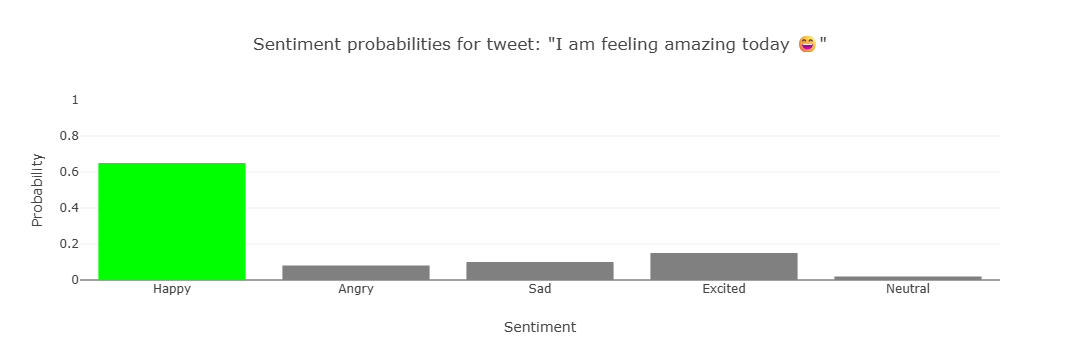

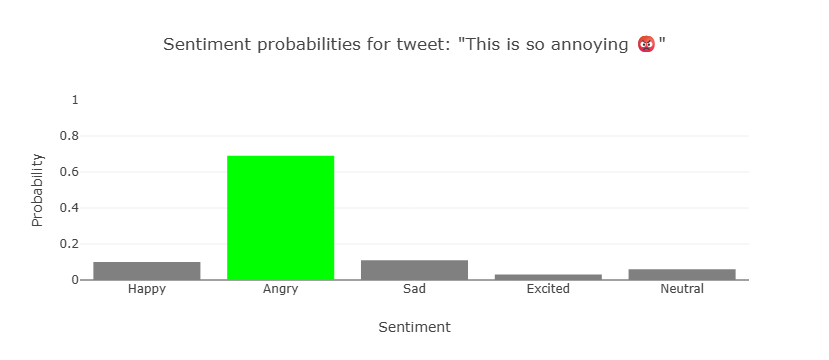

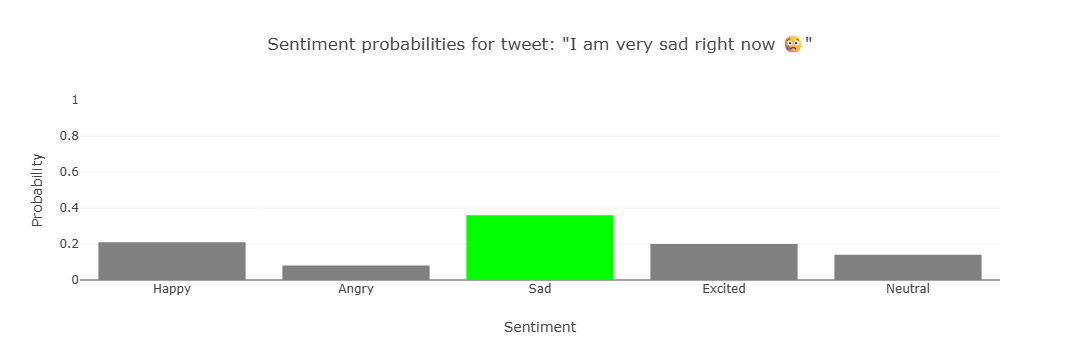

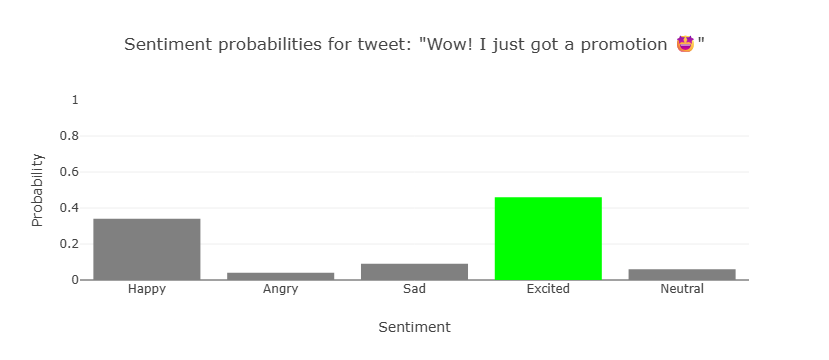

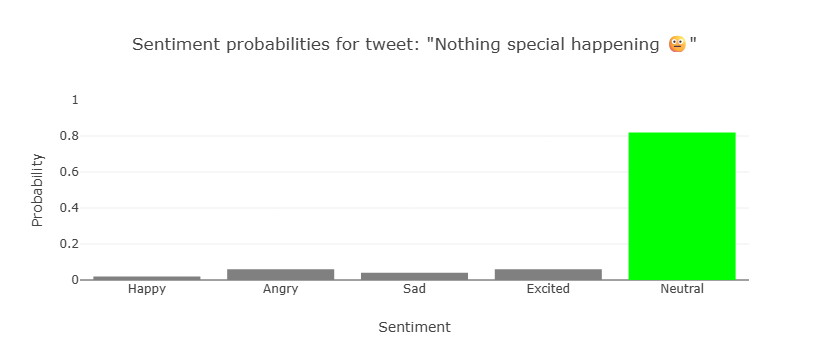

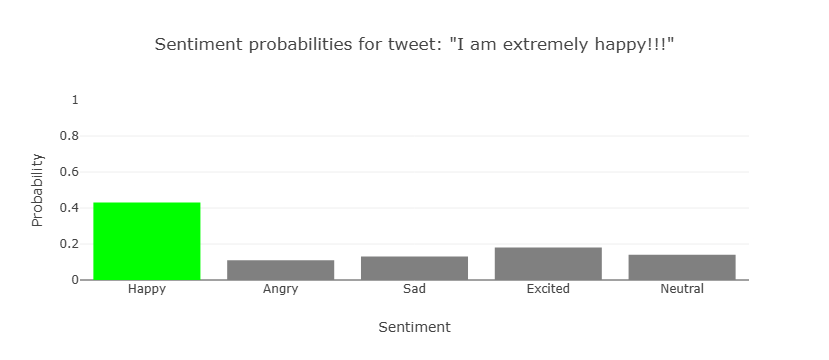

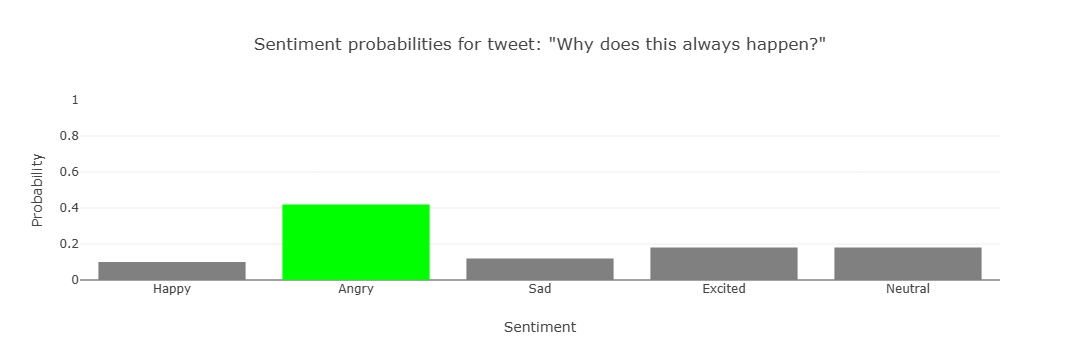

In [54]:
# 9️⃣ Visualization (interactive)
import plotly.graph_objects as go

for index, row in results_df.iterrows():
    tweet = row['Tweet']
    probs = [row['Happy Prob'], row['Angry Prob'], row['Sad Prob'], row['Excited Prob'], row['Neutral Prob']]
    labels = ['Happy', 'Angry', 'Sad', 'Excited', 'Neutral']
    colors = ['#00FF00' if p == max(probs) else '#808080' for p in probs]  # Highlight predicted sentiment
    
    fig = go.Figure([go.Bar(
        x=labels,
        y=probs,
        marker_color=colors
    )])
    
    fig.update_layout(
        title=f"Sentiment probabilities for tweet:\n\"{tweet}\"",
        yaxis=dict(range=[0,1]),
        xaxis_title="Sentiment",
        yaxis_title="Probability"
    )
    
    fig.show()


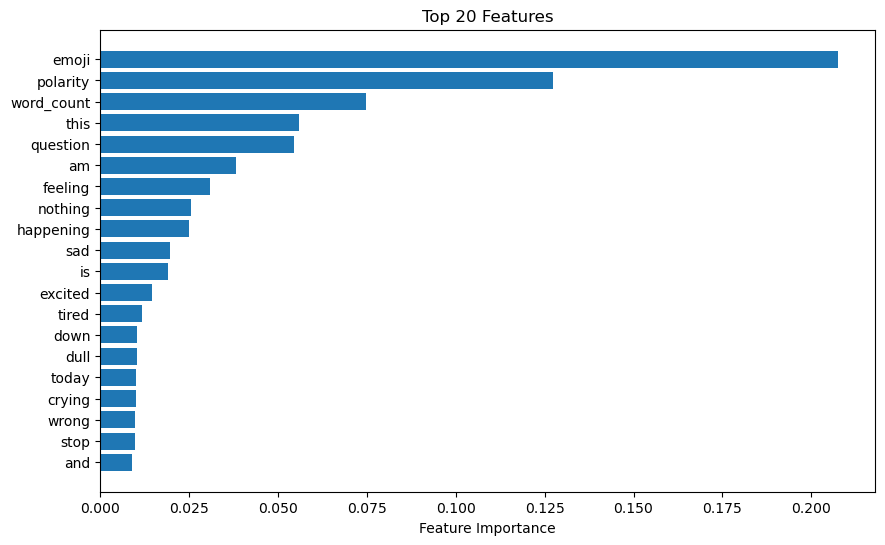

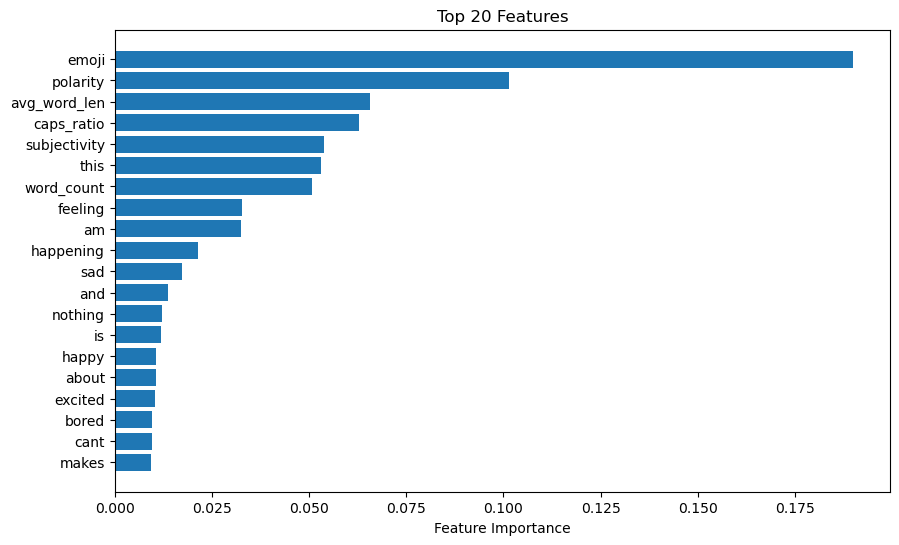

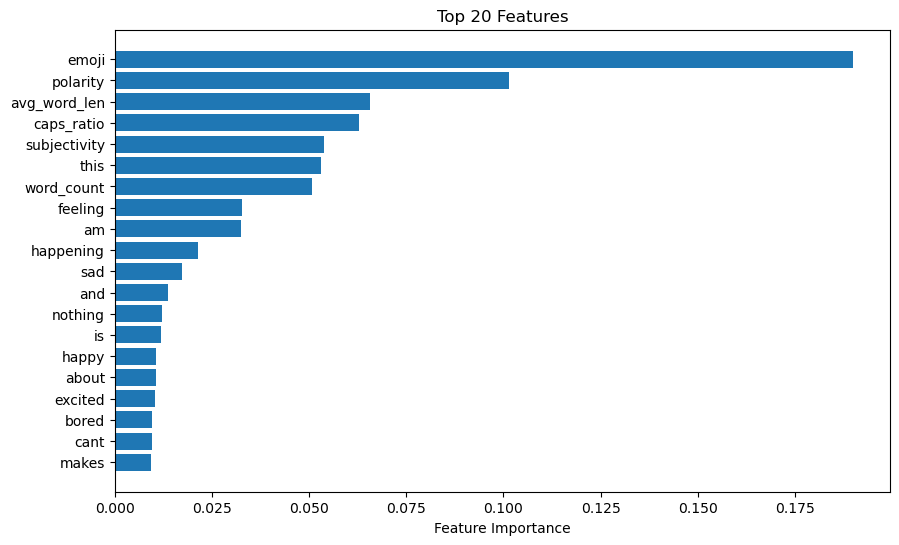

In [55]:
tfidf_features = vectorizer.get_feature_names_out()
extra_feature_names = ['emoji', 'polarity', 'subjectivity', 'exclamation', 'question', 
                       'word_count', 'avg_word_len', 'hashtags', 'mentions', 'caps_ratio']
all_features = list(tfidf_features) + extra_feature_names

importances = clf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features")
plt.show()

Enter a tweet (or type 'exit' to quit):  I am both happy and sad today



Predicted Sentiment: happy
Probabilities:
angry: 0.10
excited: 0.26
happy: 0.39
neutral: 0.09
sad: 0.17


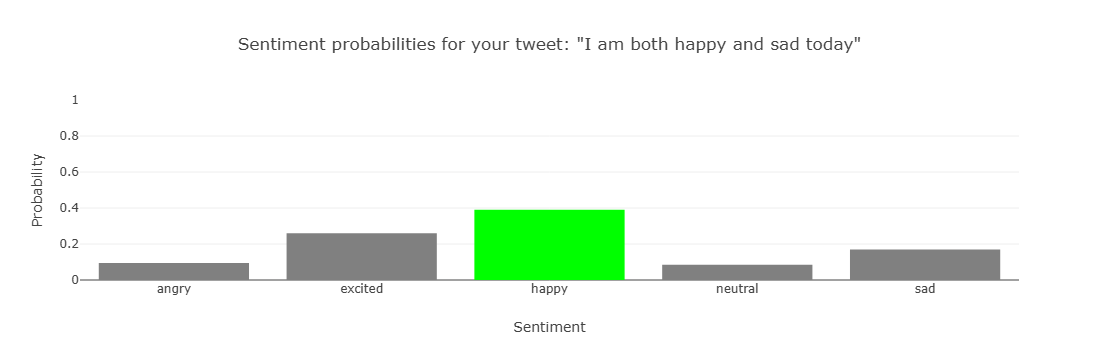

Enter a tweet (or type 'exit' to quit):  i am sad and happy today 



Predicted Sentiment: happy
Probabilities:
angry: 0.07
excited: 0.30
happy: 0.34
neutral: 0.12
sad: 0.16


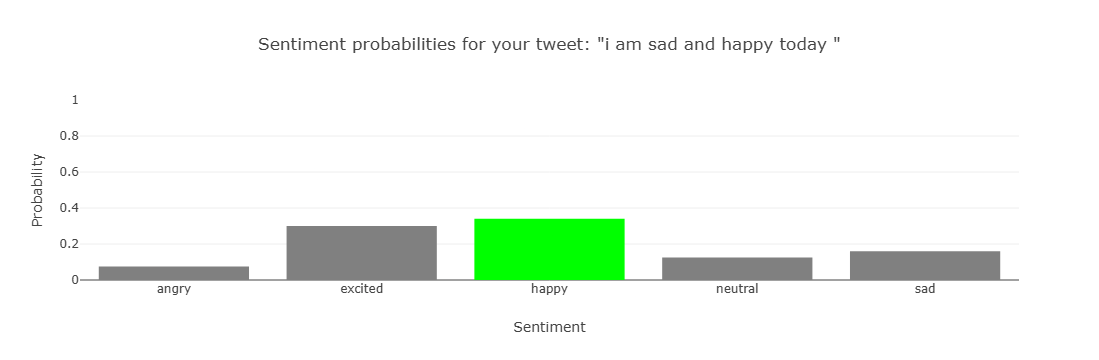

In [ ]:
# Dynamic user input for sentiment prediction
while True:
    tweet_input = input("Enter a tweet (or type 'exit' to quit): ")
    if tweet_input.lower() == 'exit':
        print("Exiting...")
        break
    
    # Predict
    pred, prob = predict_tweet(tweet_input)
    
    # Display results
    print(f"\nPredicted Sentiment: {pred}")
    print("Probabilities:")
    for cls, p in zip(le.classes_, prob):
        print(f"{cls}: {p:.2f}")
    
    # Plot probability bar chart
    labels = le.classes_
    colors = ['#00FF00' if p == max(prob) else '#808080' for p in prob]  # Highlight predicted sentiment
    
    fig = go.Figure([go.Bar(
        x=labels,
        y=prob,
        marker_color=colors
    )])
    
    fig.update_layout(
        title=f"Sentiment probabilities for your tweet:\n\"{tweet_input}\"",
        yaxis=dict(range=[0,1]),
        xaxis_title="Sentiment",
        yaxis_title="Probability"
    )
    
    fig.show()
